In [1]:
# Import pandas for data handling
import pandas as pd

import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# NLTK is our Natural-Language-Took-Kit
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Libraries for helping us with strings
import string
# Regular Expression Library
import re
# import json
import json

# Import our text vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


# Import our classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier


# Import some ML helper function
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score ,confusion_matrix


# Import our metrics to evaluate our model
from sklearn import metrics
from sklearn.metrics import classification_report


# Library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# You may need to download these from nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
list_dic = []
with open('data/News_Category_Dataset_v2.json') as json_file:
    for the_file in json_file:
        list_dic.append(json.loads(the_file))

In [3]:
len(list_dic)

200853

In [4]:
df = pd.DataFrame(list_dic)

In [5]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [6]:
df.isnull().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

In [7]:
df.duplicated().sum()

13

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [9]:
df.category.value_counts()

POLITICS          32738
WELLNESS          17824
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9646
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3489
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2078
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1322
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

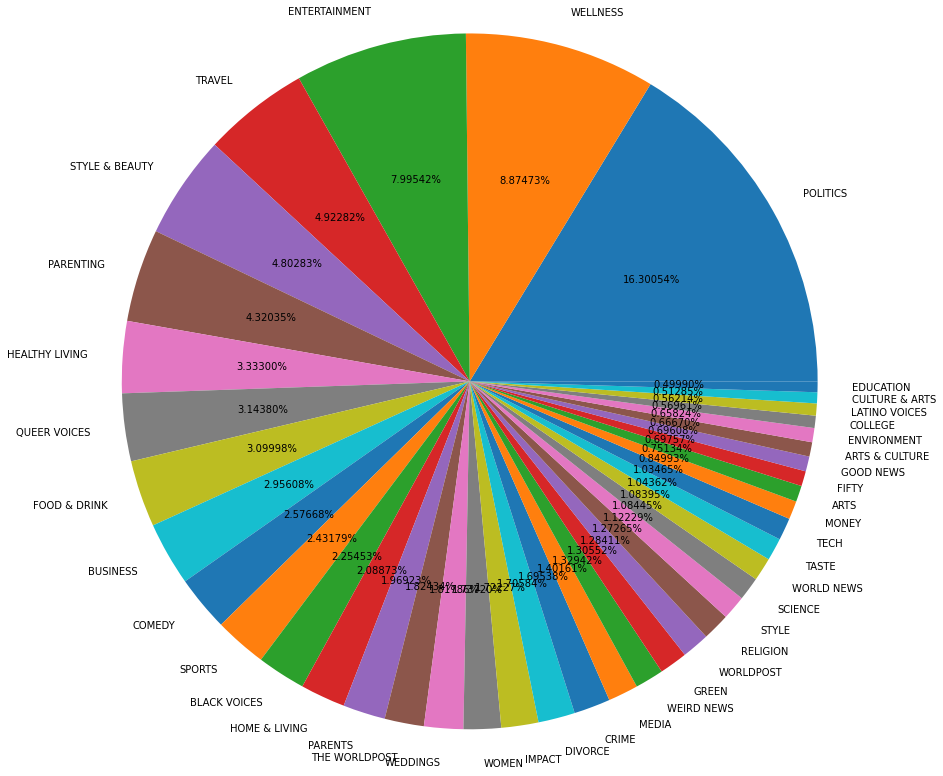

In [10]:
data = df.category.value_counts()

plt.pie(data , labels = data.keys(), autopct="%0.5f%%", radius = 4)
plt.show()

## Helper funcitons for text

In [11]:
#functions to clean up text
def return_lower(text):
    return text.lower()

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]','', text)
    return text

def remove_stopwords(text):
    words = word_tokenize(text)
    valid_words = []
    for word in words:
        if word not in stopwords:
            valid_words.append(word)
    text = " ".join(valid_words)
    return text;

def stem_words(text):
    #initialize stemmer
    porter = PorterStemmer()
    #tokenize words
    words = word_tokenize(text)
    #place to append valid words
    valid_words = []
    
    for word in words:
        stem_word = porter.stem(word)
        valid_words.append(stem_word)
    text = " ".join(valid_words)
    return text

def text_pipeline(input_string):
    input_string = return_lower(input_string)
    input_string = remove_punctuation(input_string)
    #input_string = remove_stopwords(input_string)
    #input_string = stem_words(input_string)
    return input_string

In [12]:
df['headline_clean'] = df['headline'].apply(text_pipeline)

print("ORIGINAL TEXT\n:", df['headline'][0])
print("CLEANDED TEXT\n:", df['headline_clean'][0])

ORIGINAL TEXT
: There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV
CLEANDED TEXT
: there were 2 mass shootings in texas last week but only 1 on tv


# Goal: make a subsampled df where we get an even value counts

In [13]:
categories = df.category.unique()
categories

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

## Group similar categories, bigger buckets & better predicitons

In [14]:
def regroup(grouplist,name):
    for cat in categories:
        if cat in grouplist:
            df.loc[df['category'] == cat, 'category'] = name

In [15]:
regroup( grouplist= ['WELLNESS', 'HEALTHY LIVING','HOME & LIVING','STYLE & BEAUTY' ,'STYLE'] , name =  'LIFESTYLE AND WELLNESS')

regroup( grouplist= ['PARENTING', 'PARENTS' ,'EDUCATION' ,'COLLEGE'] , name =  'PARENTING AND EDUCATION')

regroup( grouplist= ['SPORTS','ENTERTAINMENT' , 'COMEDY', 'WEIRD NEWS', 'ARTS'] , name =  'SPORTS AND ENTERTAINMENT')

regroup( grouplist= ['TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE'] , name =  'TRAVEL-TOURISM & ART-CULTURE')

regroup( grouplist= ['WOMEN', 'QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'EMPOWERED VOICES')

regroup( grouplist= ['BUSINESS',  'MONEY'] , name =  'BUSINESS-MONEY')

regroup( grouplist= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS'] , name =  'WORLDNEWS')

regroup( grouplist= ['ENVIRONMENT', 'GREEN'] , name =  'ENVIRONMENT')

regroup( grouplist= ['TECH', 'SCIENCE'] , name =  'SCIENCE AND TECH')

regroup( grouplist= ['FIFTY', 'IMPACT' ,'GOOD NEWS', 'CRIME'] , name =  'GENERAL')

regroup( grouplist= ['WEDDINGS', 'DIVORCE',  'RELIGION', 'MEDIA'] , name =  'MISC')

In [16]:
df.category.value_counts()

LIFESTYLE AND WELLNESS          40613
POLITICS                        32738
SPORTS AND ENTERTAINMENT        30296
TRAVEL-TOURISM & ART-CULTURE    20578
EMPOWERED VOICES                15460
PARENTING AND EDUCATION         14780
MISC                            12448
GENERAL                          9663
WORLDNEWS                        8420
BUSINESS-MONEY                   7644
SCIENCE AND TECH                 4256
ENVIRONMENT                      3944
Name: category, dtype: int64

In [17]:
df.duplicated().sum()

0

In [18]:
print(len(df[df['headline'] == ""]))

6


In [19]:
df.loc[df['headline'] == "", 'headline'] = np.nan
df.dropna(subset=['headline'], inplace=True)
print(len(df[df['headline'] == ""]))

0


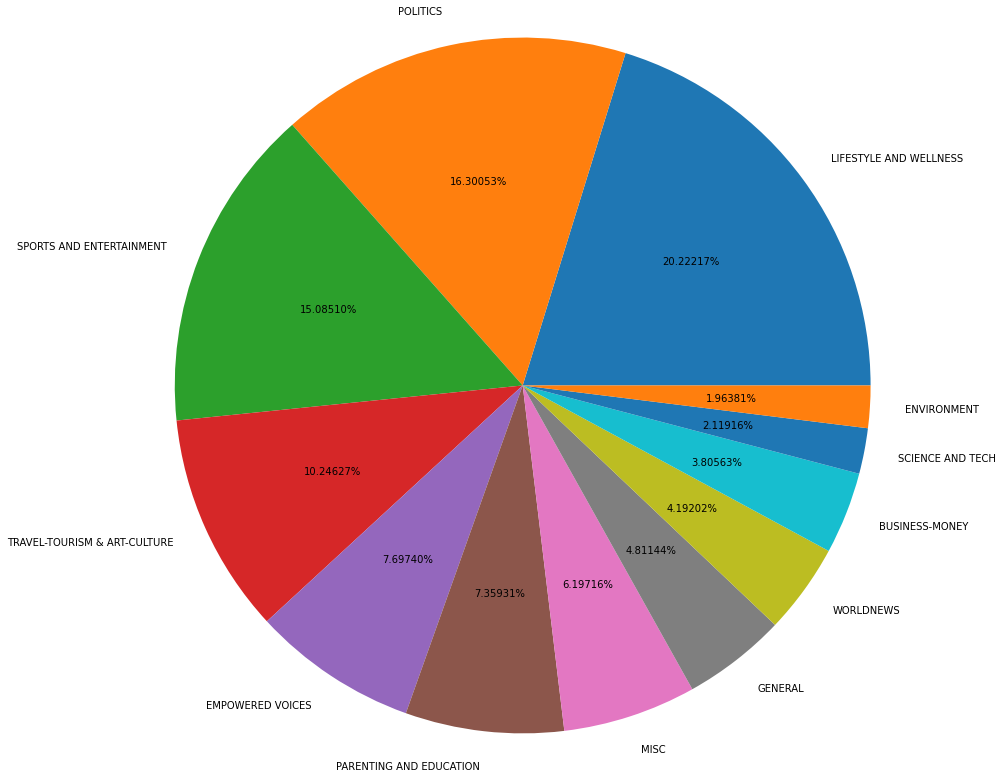

In [20]:
data = df.category.value_counts()

plt.pie(data , labels = data.keys(), autopct="%0.5f%%", radius = 4)
plt.show()

## We still have an imbalance, so we try to make it balanced

In [21]:
X = df['headline_clean'].values
y = df['category'].values

vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [22]:
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
X_rus, y_rus = rus.fit_resample(X, y)

In [23]:
print('original dataset shape:', y.shape, X.shape)
print('Resample dataset shape', y_rus.shape, X_rus.shape)

original dataset shape: (200834,) (200834, 67431)
Resample dataset shape (47328,) (47328, 67431)


In [24]:
total_rus = pd.DataFrame(y_rus, columns = ['category'])
total_rus.category.value_counts()

BUSINESS-MONEY                  3944
GENERAL                         3944
LIFESTYLE AND WELLNESS          3944
EMPOWERED VOICES                3944
MISC                            3944
PARENTING AND EDUCATION         3944
ENVIRONMENT                     3944
SPORTS AND ENTERTAINMENT        3944
TRAVEL-TOURISM & ART-CULTURE    3944
POLITICS                        3944
SCIENCE AND TECH                3944
WORLDNEWS                       3944
Name: category, dtype: int64

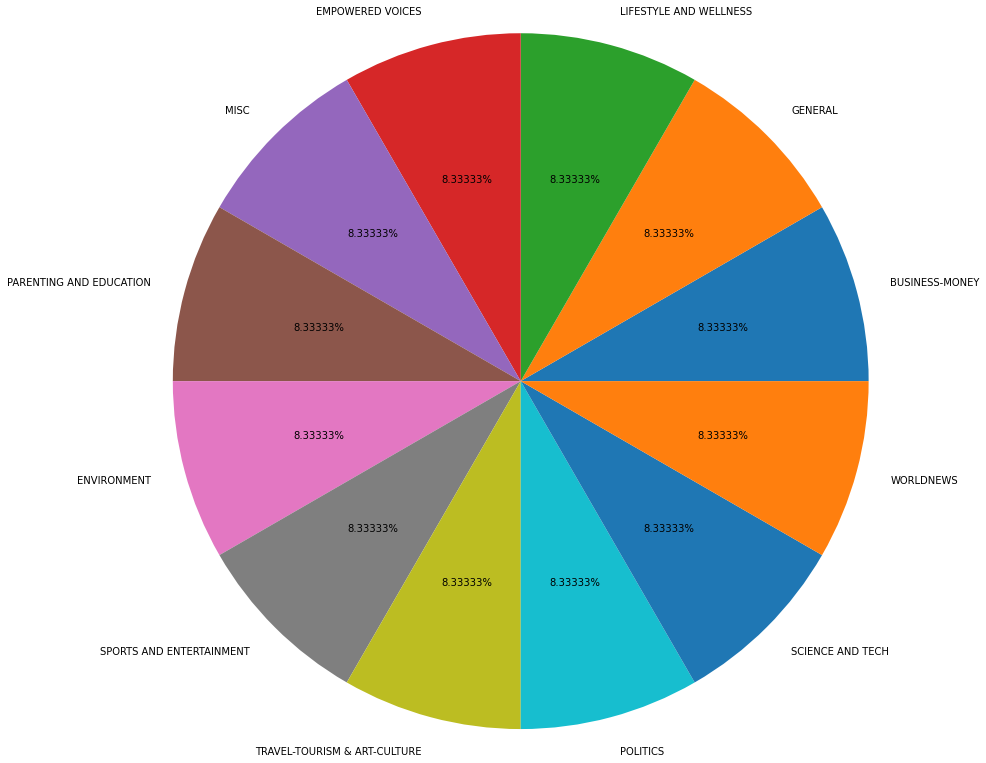

In [25]:
data = total_rus.category.value_counts()
plt.pie(data, labels = data.keys(), autopct="%0.5f%%", radius = 4)
plt.show()

# Train and test Models

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=102121)

{'alpha': 0.4}
Model Accuracy: 0.637545


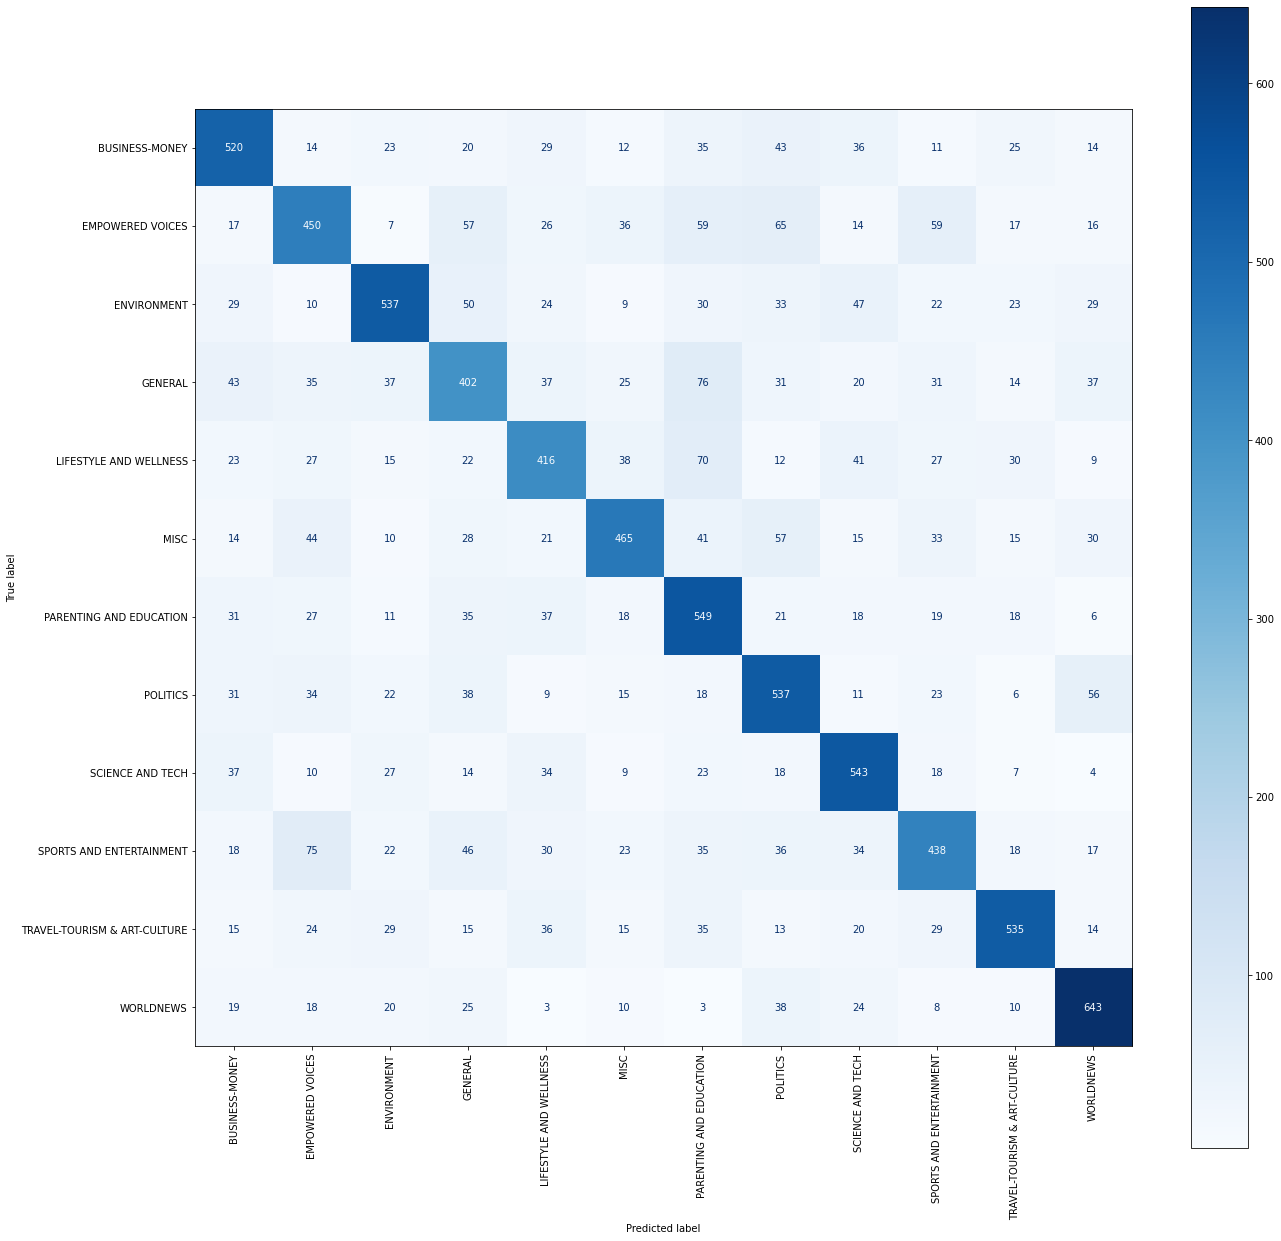

In [27]:
params = {
    'alpha':[ 0.1, 0.2, 0.4, 1],
}

grid_search_cv = GridSearchCV(
    estimator = MultinomialNB(),
    param_grid = params,
    scoring = 'f1_weighted'
)

grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_params_)

model = grid_search_cv.best_estimator_

#Evaluate model
accuracy = model.score(X_test, y_test)
print("Model Accuracy: %f" % accuracy)

# Confusion matrix of our predictions
fig, ax = plt.subplots(figsize=(21, 21))

disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=model.classes_,
                             cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
disp

## Attempt: Oversample (SMOTE) and use k-cross validation

My guess: too many similar things, will be poorer model

In [28]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', y.shape[0])
print('Resample dataset shape', y_smote.shape[0])

Original dataset shape 200834
Resample dataset shape 487356


In [29]:
total_smote = pd.DataFrame(y_smote, columns = ['category'])
total_smote.category.value_counts()

TRAVEL-TOURISM & ART-CULTURE    40613
LIFESTYLE AND WELLNESS          40613
ENVIRONMENT                     40613
WORLDNEWS                       40613
EMPOWERED VOICES                40613
MISC                            40613
PARENTING AND EDUCATION         40613
GENERAL                         40613
POLITICS                        40613
BUSINESS-MONEY                  40613
SCIENCE AND TECH                40613
SPORTS AND ENTERTAINMENT        40613
Name: category, dtype: int64

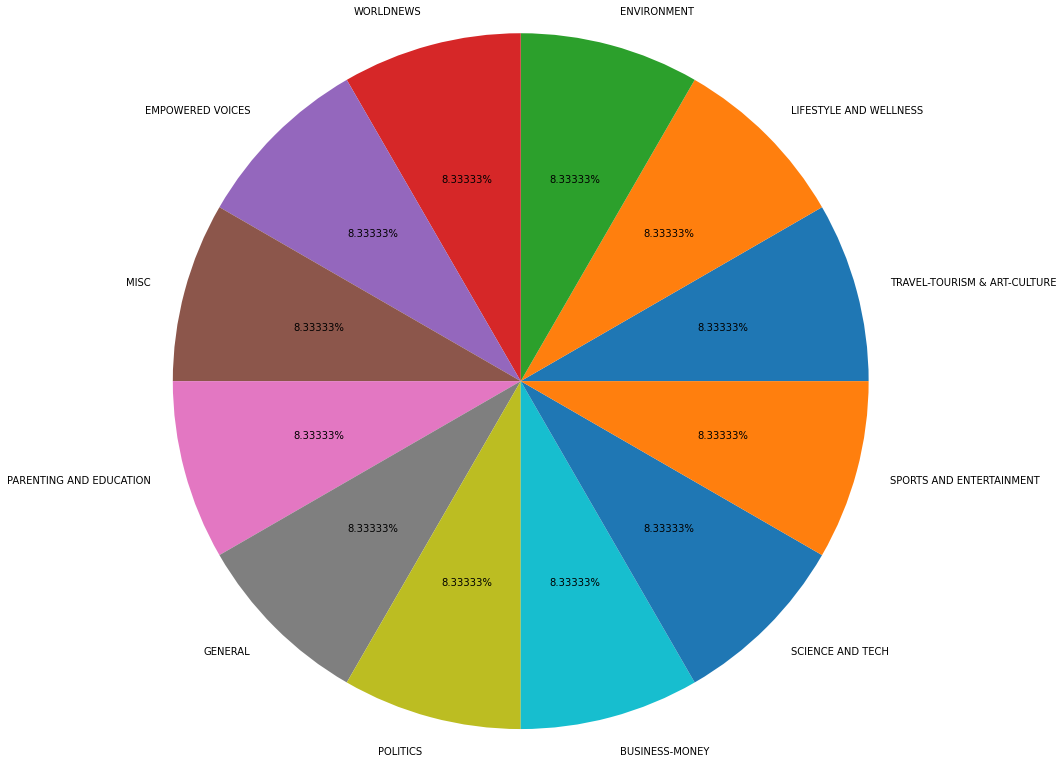

In [30]:
data = total_smote.category.value_counts()
plt.pie(data, labels = data.keys(), autopct="%0.5f%%", radius = 4)
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.4, random_state=0)

{'alpha': 0.1}
Model Accuracy: 0.790600


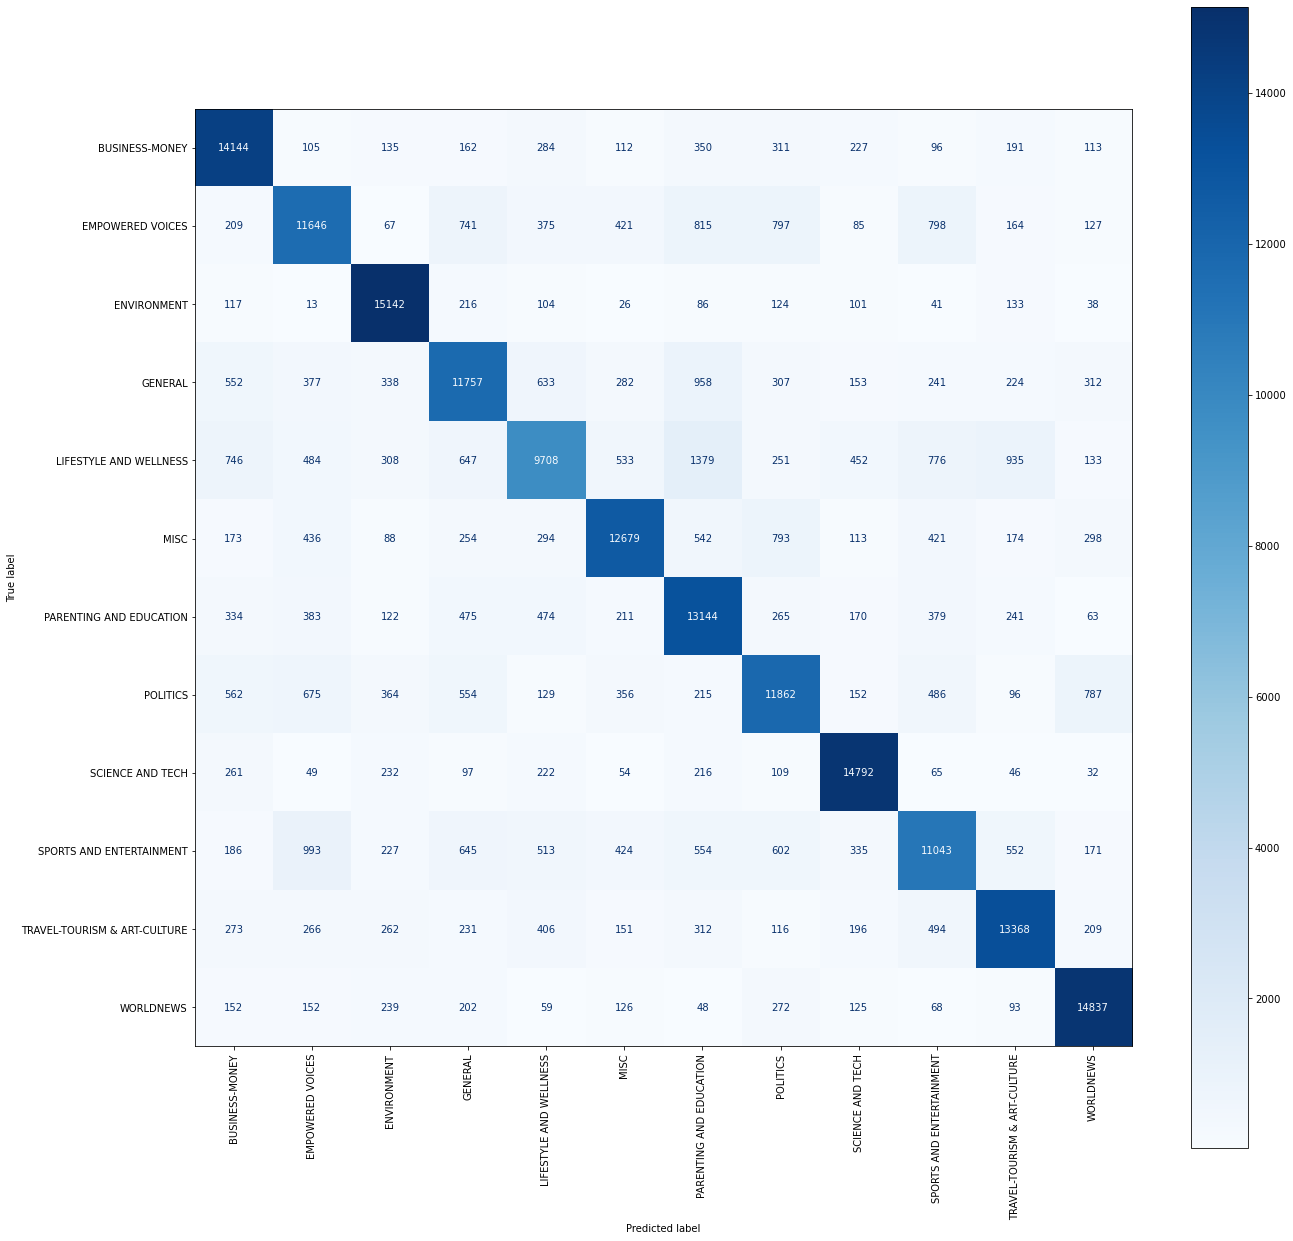

In [32]:
params = {
    'alpha':[ 0.1, 0.2, 0.4, 1],
}

grid_search_cv = GridSearchCV(
    estimator = MultinomialNB(),
    param_grid = params,
    scoring = 'f1_weighted'
)

grid_search_cv.fit(X_train, y_train)
print(grid_search_cv.best_params_)

model = grid_search_cv.best_estimator_

#Evaluate model
accuracy = model.score(X_test, y_test)
print("Model Accuracy: %f" % accuracy)

# Confusion matrix of our predictions
fig, ax = plt.subplots(figsize=(21, 21))

disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=model.classes_,
                             cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
disp

In [33]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=model.classes_))

                              precision    recall  f1-score   support

              BUSINESS-MONEY       0.80      0.87      0.83     16230
            EMPOWERED VOICES       0.75      0.72      0.73     16245
                 ENVIRONMENT       0.86      0.94      0.90     16141
                     GENERAL       0.74      0.73      0.73     16134
      LIFESTYLE AND WELLNESS       0.74      0.59      0.66     16352
                        MISC       0.82      0.78      0.80     16265
     PARENTING AND EDUCATION       0.71      0.81      0.75     16261
                    POLITICS       0.75      0.73      0.74     16238
            SCIENCE AND TECH       0.88      0.91      0.89     16175
    SPORTS AND ENTERTAINMENT       0.74      0.68      0.71     16245
TRAVEL-TOURISM & ART-CULTURE       0.82      0.82      0.82     16284
                   WORLDNEWS       0.87      0.91      0.89     16373

                    accuracy                           0.79    194943
                  

In [34]:
def predictText(text):
    print(text)
    xIn = text_pipeline(text)
    xIn = vectorizer.transform([xIn])
    print('Predicted category: ', model.predict(xIn)[0])
    data = {
        'Category': np.unique(y_smote),
        'weight': model.predict_proba(xIn)[0],
    }
    results = pd.DataFrame(data)
    print( results.sort_values('weight', ascending=False))
    print(model.predict_proba(xIn))

In [35]:
titleSet = [
    'Obama Presidential Election Scandal',
    "Trump to launch new social media platform TRUTH Social",
    'Taxi-hailing firm reveals 4,158 reports of sexual assault',
    'Students sue Texas school district for banning long hair on boys',
    'Crime-hit Chicago grapples with police vaccine revolt'
]
for title in titleSet:
    predictText(title)
    print()

Obama Presidential Election Scandal
Predicted category:  POLITICS
                        Category    weight
7                       POLITICS  0.690162
11                     WORLDNEWS  0.159866
0                 BUSINESS-MONEY  0.036340
1               EMPOWERED VOICES  0.034466
9       SPORTS AND ENTERTAINMENT  0.033105
5                           MISC  0.025483
6        PARENTING AND EDUCATION  0.005827
2                    ENVIRONMENT  0.005734
4         LIFESTYLE AND WELLNESS  0.003661
3                        GENERAL  0.002362
8               SCIENCE AND TECH  0.001556
10  TRAVEL-TOURISM & ART-CULTURE  0.001438
[[0.03633968 0.03446616 0.00573389 0.00236222 0.00366131 0.02548267
  0.0058271  0.69016196 0.00155617 0.03310533 0.00143757 0.15986594]]

Trump to launch new social media platform TRUTH Social
Predicted category:  SCIENCE AND TECH
                        Category    weight
8               SCIENCE AND TECH  0.294993
5                           MISC  0.206914
0             